In [1]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

In [2]:
import tensorflow as tf
print(tf.test.gpu_device_name())
# See https://www.tensorflow.org/tutorials/using_gpu#allowing_gpu_memory_growth
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

/device:GPU:0


In [5]:
import os
import pandas as pd

import numpy as np
from glob import glob
import cv2
import skimage
from skimage.transform import resize

from keras import layers
from keras import models
from keras import optimizers
from keras.models import load_model
import keras.callbacks as kcall
from keras.optimizers import Adam
from keras.models import Model
from keras.models import Sequential
from keras.layers import Flatten, Dense, Activation, Dropout, Conv2D, MaxPooling2D, BatchNormalization
from keras.applications.xception import Xception, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt

%matplotlib inline

Using TensorFlow backend.


In [6]:
train_dir = 'data-without-aug/train'
validation_dir = 'data-without-aug/validation'

In [7]:
for root,dirs,files in os.walk(train_dir):
    print (root, len(files))

data-without-aug/train 0
data-without-aug/train\AKIEC 253
data-without-aug/train\BCC 247
data-without-aug/train\BKL 815
data-without-aug/train\DF 85
data-without-aug/train\MEL 801
data-without-aug/train\NV 4975
data-without-aug/train\VASC 109


In [8]:
for root,dirs,files in os.walk(validation_dir):
    print (root, len(files))

data-without-aug/validation 0
data-without-aug/validation\AKIEC 74
data-without-aug/validation\BCC 139
data-without-aug/validation\BKL 284
data-without-aug/validation\DF 30
data-without-aug/validation\MEL 312
data-without-aug/validation\NV 1730
data-without-aug/validation\VASC 33


In [9]:
from keras.preprocessing.image import ImageDataGenerator

# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    featurewise_center=True,
    featurewise_std_normalization=True)


# target_size = (height, width)
target_size = (225, 300)


train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size = target_size,       
        class_mode = 'categorical',
        shuffle = True)

validation_generator = train_datagen.flow_from_directory(
        validation_dir,
        target_size = target_size,        
        class_mode = 'categorical',
        shuffle = True)

Found 7285 images belonging to 7 classes.
Found 2602 images belonging to 7 classes.


In [10]:
import keras.backend as K

def precision(y_true, y_pred):
    # Calculates the precision
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def recall(y_true, y_pred):
    # Calculates the recall
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def fbeta_score(y_true, y_pred, beta=1):
    # Calculates the F score, the weighted harmonic mean of precision and recall.

    if beta < 0:
        raise ValueError('The lowest choosable beta is zero (only precision).')
        
    # If there are no true positives, fix the F score at 0 like sklearn.
    if K.sum(K.round(K.clip(y_true, 0, 1))) == 0:
        return 0

    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    bb = beta ** 2
    fbeta_score = (1 + bb) * (p * r) / (bb * p + r + K.epsilon())
    return fbeta_score

def fmeasure(y_true, y_pred):
    # Calculates the f-measure, the harmonic mean of precision and recall.
    return fbeta_score(y_true, y_pred, beta=1)

In [11]:
## Intilizing variables
output_classes = 7

batch_size = 32 
epochs = 50
droput_rate= 0.5

adam_opt = Adam(lr=1e-5, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=1e-5)
resnet50_weights = 'pretrained-models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'

In [12]:
from keras.applications import ResNet50
from keras.layers import Flatten, Dense, Dropout, BatchNormalization
from keras.regularizers import l2

model = (ResNet50(include_top=False, pooling='avg', weights=resnet50_weights))
x = model.output
# x = Flatten()(x)
x = Dense(1024, activation="relu", kernel_regularizer=l2(0.0001), bias_regularizer=l2(0.0001))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation="relu", kernel_regularizer=l2(0.0001), bias_regularizer=l2(0.0001))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
predictions = Dense(7, activation="softmax", kernel_regularizer=l2(0.0001), bias_regularizer=l2(0.0001))(x)
model = Model(input = model.input, output = predictions)


model.compile(loss='categorical_crossentropy',
              optimizer= adam_opt,
              metrics = ["categorical_accuracy", fmeasure, recall, precision])


In [13]:
history = model.fit_generator(train_generator,
    steps_per_epoch=2048,
    epochs = epochs,
    validation_data = validation_generator,
    validation_steps=1024)

Epoch 1/50
2048/2048 [==============================] - 925s 451ms/step - loss: 1.6312 - categorical_accuracy: 0.6304 - fmeasure: 0.6249 - recall: 0.5767 - precision: 0.6877 - val_loss: 0.9094 - val_categorical_accuracy: 0.8119 - val_fmeasure: 0.8121 - val_recall: 0.7791 - val_precision: 0.8492
Epoch 2/50
2048/2048 [==============================] - 889s 434ms/step - loss: 0.5891 - categorical_accuracy: 0.8984 - fmeasure: 0.8991 - recall: 0.8818 - precision: 0.9180 - val_loss: 0.9599 - val_categorical_accuracy: 0.8330 - val_fmeasure: 0.8366 - val_recall: 0.8199 - val_precision: 0.8547
Epoch 3/50
2048/2048 [==============================] - 891s 435ms/step - loss: 0.3400 - categorical_accuracy: 0.9735 - fmeasure: 0.9732 - recall: 0.9692 - precision: 0.9774 - val_loss: 1.0083 - val_categorical_accuracy: 0.8318 - val_fmeasure: 0.8355 - val_recall: 0.8276 - val_precision: 0.8438
Epoch 4/50
2048/2048 [==============================] - 888s 434ms/step - loss: 0.2923 - categorical_accuracy: 0

Epoch 29/50
2048/2048 [==============================] - 899s 439ms/step - loss: 0.1707 - categorical_accuracy: 0.9993 - fmeasure: 0.9993 - recall: 0.9993 - precision: 0.9993 - val_loss: 1.1366 - val_categorical_accuracy: 0.8631 - val_fmeasure: 0.8637 - val_recall: 0.8620 - val_precision: 0.8656
Epoch 30/50
2048/2048 [==============================] - 894s 437ms/step - loss: 0.1681 - categorical_accuracy: 0.9993 - fmeasure: 0.9993 - recall: 0.9992 - precision: 0.9993 - val_loss: 1.1500 - val_categorical_accuracy: 0.8576 - val_fmeasure: 0.8587 - val_recall: 0.8576 - val_precision: 0.8599
Epoch 31/50
2048/2048 [==============================] - 893s 436ms/step - loss: 0.1655 - categorical_accuracy: 0.9992 - fmeasure: 0.9992 - recall: 0.9991 - precision: 0.9992 - val_loss: 1.1233 - val_categorical_accuracy: 0.8634 - val_fmeasure: 0.8644 - val_recall: 0.8634 - val_precision: 0.8654
Epoch 32/50
2048/2048 [==============================] - 893s 436ms/step - loss: 0.1622 - categorical_accurac

In [20]:
score = model.evaluate_generator(validation_generator, steps=50)

print ('Test Score: ', score[0])
print ('Test Accuracy: ',score[1])
print ('fmeasure: ', score[2])
print ('Recall: ', score[3])
print ('Precision: ', score[4])

Test Score:  1.131708471775055
Test Accuracy:  0.860625
fmeasure:  0.8601884305477142
Recall:  0.859375
Precision:  0.8610282242298126


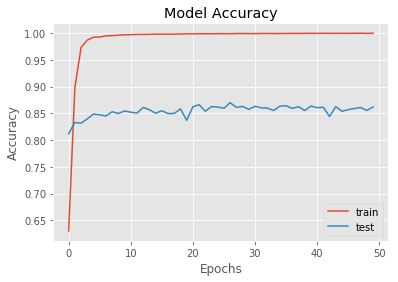

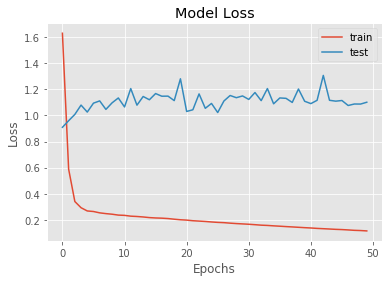

In [22]:
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

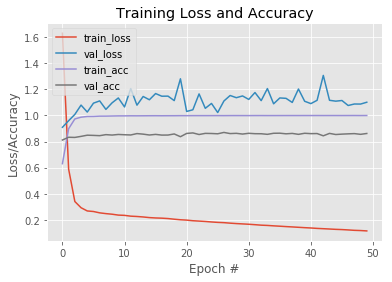

In [23]:
plt.style.use("ggplot")
plt.figure()
N = epochs
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["categorical_accuracy"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_categorical_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper left")

In [24]:
from keras.preprocessing.image import ImageDataGenerator

# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    featurewise_center=True,
    featurewise_std_normalization=True)


# target_size = (height, width)
target_size = (225, 300)


train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size = target_size,       
        class_mode = 'categorical',
        shuffle = False)

validation_generator = train_datagen.flow_from_directory(
        validation_dir,
        target_size = target_size,        
        class_mode = 'categorical',
        shuffle = False)

Found 7285 images belonging to 7 classes.
Found 2602 images belonging to 7 classes.


In [25]:
filename = validation_generator.filenames
truth = validation_generator.classes
label = validation_generator.class_indices
indexlabel = dict((value, key) for key, value in label.items())

In [26]:
predicts = model.predict_generator(validation_generator, steps=validation_generator.samples/validation_generator.batch_size, verbose=1)
predict_class = np.argmax(predicts, axis=1)
errors = np.where(predict_class != truth)[0]
print("No of errors = {}/{}".format(len(errors),validation_generator.samples))

82/81 [==============================] - 14s 172ms/step
No of errors = 358/2602


Confusion Matrix
[[  42    1    7    1    7   16    0]
 [  15   82   10    3    8   20    1]
 [   7    2  216    0   13   46    0]
 [   0    1    1   21    1    6    0]
 [   6    4   27    1  164  110    0]
 [   0    2   14    0   22 1690    2]
 [   0    0    2    0    1    1   29]]


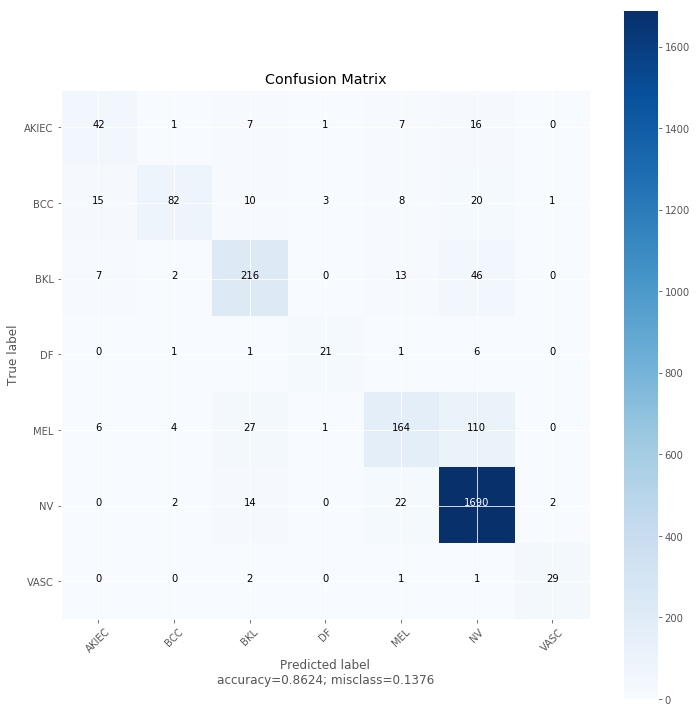

In [30]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(truth,predict_class)

labels = []
for k,v in indexlabel.items():
    labels.append(v)
    
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.savefig('plots/5.VGG19-CM.png', bbox_inches='tight', dpi = 100)

plt.figure(figsize=(10,10))


plot_confusion_matrix(cm, classes=labels,
                      title='Confusion Matrix')

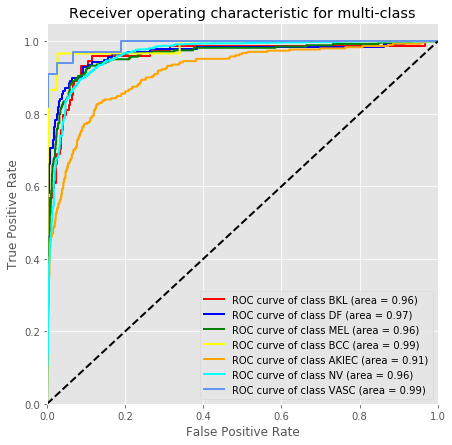

In [31]:


#ROC Curve for each class
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
import matplotlib.pyplot as plt
%matplotlib inline  
from scipy import interp
from itertools import cycle


y_pred = predicts
y_pred_probabilities=y_pred

y_pred = np.argmax(y_pred,axis = 1) 
y_actual = validation_generator.classes

classnames=[]
for classname in validation_generator.class_indices:
    classnames.append(classname)

y_actual_binary = label_binarize(y_actual, classes=[0, 1, 2, 3, 4,5,6])
y_pred_binary = y_pred_probabilities#label_binarize(y_pred_probabilities, classes=[0, 1, 2, 3, 4])
n_classes=7
lw=2

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_actual_binary[:, i], y_pred_binary[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_actual_binary.ravel(), y_pred_binary.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(7, 7))


colors = cycle(['red','blue','green','yellow','orange', 'aqua', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(classnames[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class')
plt.legend(loc="best")
plt.show()



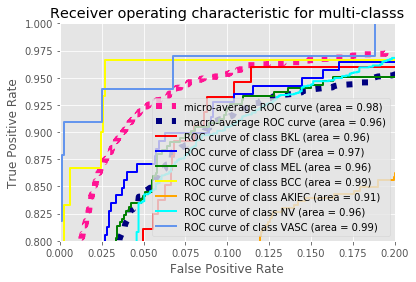

In [32]:
# Zoom in view of the upper left corner.
plt.figure(2)
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)

plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=6)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=6)


colors = cycle(['red','blue','green','yellow','orange', 'aqua', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(classnames[i], roc_auc[i]))

    
    
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-classs')
plt.legend(loc="lower right")
plt.savefig('plots/5.VGG19-ROC.png', dpi = 100)
plt.show()

In [33]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report

confusion_mtx = confusion_matrix(y_actual, y_pred) 
print(confusion_mtx)
target_names = classnames
print(classification_report(y_actual, y_pred, target_names=target_names))

[[  42    1    7    1    7   16    0]
 [  15   82   10    3    8   20    1]
 [   7    2  216    0   13   46    0]
 [   0    1    1   21    1    6    0]
 [   6    4   27    1  164  110    0]
 [   0    2   14    0   22 1690    2]
 [   0    0    2    0    1    1   29]]
              precision    recall  f1-score   support

         BKL       0.60      0.57      0.58        74
          DF       0.89      0.59      0.71       139
         MEL       0.78      0.76      0.77       284
         BCC       0.81      0.70      0.75        30
       AKIEC       0.76      0.53      0.62       312
          NV       0.89      0.98      0.93      1730
        VASC       0.91      0.88      0.89        33

   micro avg       0.86      0.86      0.86      2602
   macro avg       0.81      0.71      0.75      2602
weighted avg       0.86      0.86      0.85      2602



In [ ]:
model.save('models/4.ResNet-without-aug-Model.h5')
model.save_weights('models/4.ResNet-without-aug-Weights.h5')